In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
import pathlib
import os
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageOps
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'pandas'

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/acer/anaconda3/lib/python3.8/site-packages
Requires: h5py, grpcio, flatbuffers, opt-einsum, six, protobuf, absl-py, numpy, google-pasta, wheel, wrapt, tensorflow-estimator, astunparse, termcolor, tensorboard, keras-preprocessing, gast, typing-extensions
Required-by: 


In [10]:
!pip install tensorflow==2.4.1

  Using cached tensorflow-2.4.1-cp38-cp38-manylinux2010_x86_64.whl (394.4 MB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached numpy-1.19.5-cp38-cp38-manylinux2010_x86_64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.1
    Uninstalling tensorflow-2.3.1:
      Successfully uninstalled tensorflow-2.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.3.1 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.1

In [13]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/acer/anaconda3/envs/tf2/lib/python3.8/site-packages
Requires: protobuf, wheel, tensorflow-estimator, astunparse, numpy, flatbuffers, gast, six, tensorboard, grpcio, google-pasta, typing-extensions, h5py, opt-einsum, absl-py, wrapt, termcolor, keras-preprocessing
Required-by: 


In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.3.1


In [ ]:
'''

training_data = tf.keras.utils.get_file(fname='Training', origin='https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip', extract=True, archive_format='zip', cache_dir='data')
validation_data = tf.keras.utils.get_file(fname='Validation', origin='https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip', extract=True, archive_format='zip', cache_dir='data')
testing_data = tf.keras.utils.get_file(fname='Testing', origin='https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip', extract=True, archive_format='zip', cache_dir='data')

'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
training_data = pathlib.Path('/content/drive/MyDrive/CancerDatasets/datasets/train')
testing_data = pathlib.Path('/content/drive/MyDrive/CancerDatasets/datasets/test')
validation_data = pathlib.Path('/content/drive/MyDrive/CancerDatasets/datasets/valid')

In [ ]:
train_image_count = len(list(training_data.glob('*/*.jpg')))
print(train_image_count)

2000


In [ ]:
val_image_count = len(list(validation_data.glob('*/*.jpg')))
print(val_image_count)

150


In [ ]:
test_image_count = len(list(testing_data.glob('*/*.jpg')))
print(test_image_count)

600


## Writing Input Pipeline

In [ ]:
class_names = np.array(sorted(image.stem for image in training_data.glob('*')))
class_names

array(['melanoma', 'nevus', 'seborrheic_keratosis'], dtype='<U20')

In [ ]:
def get_label(file_path):
    path = tf.strings.split(file_path, '/')
    label = path[-2]
    y = label == class_names
    return y

In [ ]:
def get_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256,256])

In [ ]:
def get_pair(file_path):
    return get_image(file_path), get_label(file_path)

In [ ]:
train_ds = [str(img) for img in training_data.glob("*/*.jpg")]
valid_ds = [str(img) for img in validation_data.glob("*/*.jpg")]
test_ds = [str(img) for img in testing_data.glob("*/*.jpg")]

In [ ]:
# Stratified Subsampling

def create_dataset(path_list, per=0.1):
    y = [np.int(get_label(img)) for img in path_list]
    unselected_x, selected_x, unselected_y, selected_y = train_test_split(path_list, y, shuffle=True, test_size=per, stratify=y)
    return selected_x

In [ ]:
def gen_pair(path_list):
    for path in path_list:
        yield get_pair(path)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)
valid_ds = tf.data.Dataset.from_tensor_slices(valid_ds)
test_ds = tf.data.Dataset.from_tensor_slices(test_ds)

In [ ]:
train_ds = train_ds.map(get_pair)
valid_ds = valid_ds.map(get_pair)
test_ds = test_ds.map(get_pair)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)
test_ds = configure_for_performance(test_ds)

In [ ]:
test_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 3), dtype=tf.bool, name=None))

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


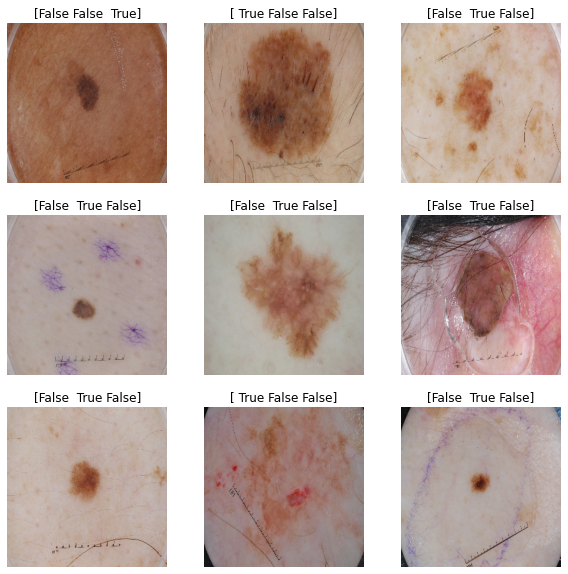

In [ ]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")

## Building Model

In [ ]:
class_names

array(['melanoma', 'nevus', 'seborrheic_keratosis'], dtype='<U20')

In [ ]:
preprocessing_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256,256,3))

In [ ]:
#---Testing Dropout

model = tf.keras.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(256,256,3)),
    layers.MaxPool2D(5,5,'same'),
    layers.Conv2D(64,5,padding='same',activation='relu'),
    layers.MaxPool2D(5,5,'same'),
    layers.Conv2D(126,5,padding='same',activation='relu'),
    layers.MaxPool2D(5,5,'same'),
    layers.Flatten(),
    layers.Dense(500,'relu'),
    layers.Dropout(0.5),
    layers.Dense(25,'relu'),
    layers.Dense(3)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 126)       201726    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 126)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1134)              0

In [ ]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
checkpoint_path = '/content/drive/MyDrive/checkpoints/cp_ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 mode='max',
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_ds, validation_data=valid_ds,epochs=20,callbacks=[cp_callback])

Epoch 1/20
63/63 [==============================] - 104s 2s/step - loss: 0.8861 - accuracy: 0.6587 - val_loss: 1.0574 - val_accuracy: 0.5200

Epoch 00001: val_accuracy improved from -inf to 0.52000, saving model to /content/drive/MyDrive/checkpoints/cp_ckpt
Epoch 2/20
63/63 [==============================] - 103s 2s/step - loss: 0.8219 - accuracy: 0.6954 - val_loss: 0.9649 - val_accuracy: 0.5200

Epoch 00002: val_accuracy did not improve from 0.52000
Epoch 3/20
63/63 [==============================] - 106s 2s/step - loss: 0.7789 - accuracy: 0.7032 - val_loss: 0.9128 - val_accuracy: 0.5200

Epoch 00003: val_accuracy did not improve from 0.52000
Epoch 4/20
63/63 [==============================] - 101s 2s/step - loss: 0.7806 - accuracy: 0.6775 - val_loss: 1.0628 - val_accuracy: 0.5200

Epoch 00004: val_accuracy did not improve from 0.52000
Epoch 5/20
63/63 [==============================] - 101s 2s/step - loss: 0.7760 - accuracy: 0.6732 - val_loss: 0.8762 - val_accuracy: 0.5267

Epoch 000

In [ ]:
model.save('/content/drive/MyDrive/checkpoints/cp_ckpt')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/cp_ckpt4/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/checkpoints/cp_ckpt')

In [ ]:
acc, loss = model.evaluate(test_ds, verbose=2)

19/19 - 9s - loss: 0.7408 - accuracy: 0.6800


## Data Augmentation

In [ ]:
img, label = next(iter(train_ds))

In [ ]:
data_augmentation = tf.keras.Sequential([
      preprocessing.Rescaling(1./255),
      preprocessing.RandomFlip("horizontal_and_vertical"),
      preprocessing.RandomRotation(0.2),
])

In [ ]:
img = img[3]
label = label[3]

img = tf.expand_dims(img, 0)

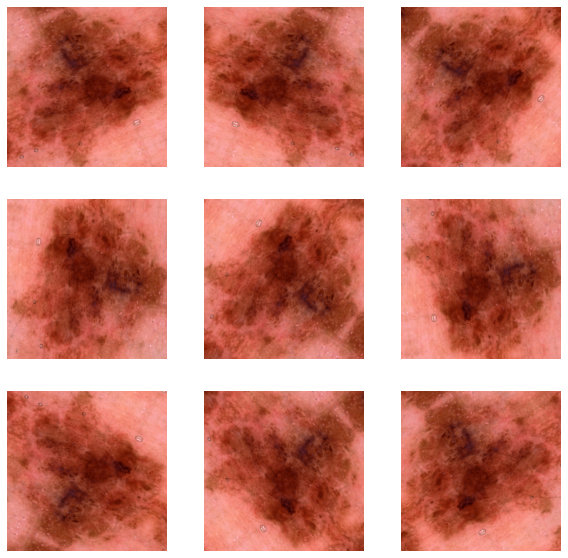

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(img)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0].numpy())
  plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
          data_augmentation,
          model
])

In [ ]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
checkpoint_path = '/content/drive/MyDrive/checkpoints/cp_ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 mode='max',
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_ds, validation_data=valid_ds,epochs=20,callbacks=[cp_callback])

Epoch 1/20
63/63 [==============================] - 101s 2s/step - loss: 0.7114 - accuracy: 0.6965 - val_loss: 0.8546 - val_accuracy: 0.5667

Epoch 00001: val_accuracy improved from -inf to 0.56667, saving model to /content/drive/MyDrive/checkpoints/cp_ckpt
Epoch 2/20
63/63 [==============================] - 100s 2s/step - loss: 0.7025 - accuracy: 0.6980 - val_loss: 0.7547 - val_accuracy: 0.6533

Epoch 00002: val_accuracy improved from 0.56667 to 0.65333, saving model to /content/drive/MyDrive/checkpoints/cp_ckpt
Epoch 3/20
63/63 [==============================] - 100s 2s/step - loss: 0.7073 - accuracy: 0.6900 - val_loss: 0.8116 - val_accuracy: 0.5867

Epoch 00003: val_accuracy did not improve from 0.65333
Epoch 4/20
63/63 [==============================] - 105s 2s/step - loss: 0.7024 - accuracy: 0.7120 - val_loss: 0.8942 - val_accuracy: 0.5267

Epoch 00004: val_accuracy did not improve from 0.65333
Epoch 5/20
63/63 [==============================] - 101s 2s/step - loss: 0.7014 - accur

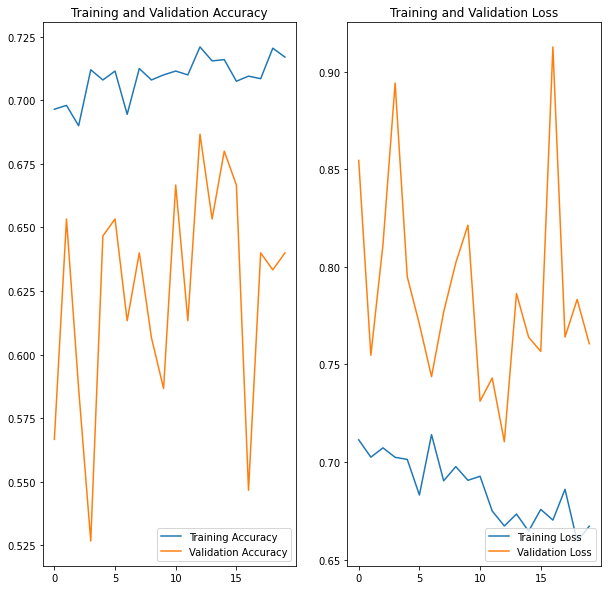

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,10))
epoch_range = range(20)
plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label="Training Accuracy")
plt.plot(epoch_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label="Training Loss")
plt.plot(epoch_range, val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
acc, loss = model.evaluate(test_ds, verbose=2)

## Transfer Learning

### Training Model for Seborrheic Keratosis

In [ ]:
class_names

array(['melanoma', 'nevus', 'seborrheic_keratosis'], dtype='<U20')

In [ ]:
def sk_get_label(file_path):
    path = tf.strings.split(file_path, '/')
    label = path[-2]
    
    if label == 'melanoma' or label == 'nevus':
      return 0
    else:
      return 1

In [ ]:
def get_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256,256])

In [ ]:
def sk_get_pair(file_path):
    return get_image(file_path), sk_get_label(file_path)

In [ ]:
sk_train_ds = [str(img) for img in training_data.glob("*/*.jpg")]
sk_valid_ds = [str(img) for img in validation_data.glob("*/*.jpg")]
sk_test_ds  = [str(img) for img in testing_data.glob("*/*.jpg")]

In [ ]:
sk_train_ds = tf.data.Dataset.from_tensor_slices(sk_train_ds)
sk_valid_ds = tf.data.Dataset.from_tensor_slices(sk_valid_ds)
sk_test_ds = tf.data.Dataset.from_tensor_slices(sk_test_ds)

In [ ]:
sk_train_ds = sk_train_ds.map(sk_get_pair)
sk_valid_ds = sk_valid_ds.map(sk_get_pair)
sk_test_ds = sk_test_ds.map(sk_get_pair)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
sk_train_ds = configure_for_performance(sk_train_ds)
sk_valid_ds = configure_for_performance(sk_valid_ds)
sk_test_ds = configure_for_performance(sk_test_ds)

In [3]:
# Model taken from https://arxiv.org/ftp/arxiv/papers/1703/1703.03108.pdf
# Model used for Transfer Learning A. Kolesnikov, L. Beyer, X. Zhai, J. Puigcerver, J. Yung, S. Gelly and N. Houlsby: Big Transfer (BiT): General Visual Representation Learning.

IMAGE_SHAPE = (256,256,3)
classifier_model = 'https://tfhub.dev/google/bit/m-r50x1/1'

classifier = tf.keras.Sequential([
          hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE)
])

In [4]:
#img, labels = next(iter(sk_train_ds))

In [5]:
data_augmentation = tf.keras.Sequential([
      preprocessing.Rescaling(1./255),
      preprocessing.RandomFlip("horizontal_and_vertical"),
      preprocessing.RandomRotation(0.2),
])

In [6]:
# Creating Ensemble Model

inputs = tf.keras.Input(shape=(256,256,3))
transformation1 = data_augmentation(inputs)
transformation2 = data_augmentation(inputs)
transformation3 = data_augmentation(inputs)

feature_set1 = classifier(inputs, training=False)
feature_set1 = layers.Dropout(0.5)(feature_set1)

feature_set2 = classifier(transformation1, training=False)
feature_set2 = layers.Dropout(0.5)(feature_set2)

feature_set3 = classifier(transformation2, training=False)
feature_set3 = layers.Dropout(0.5)(feature_set3)

feature_set4 = classifier(transformation3, training=False)
feature_set4 = layers.Dropout(0.5)(feature_set4)

x = layers.concatenate([feature_set1, feature_set2, feature_set3, feature_set4])
output = layers.Dense(1, activation='sigmoid')(x)

seborrheic_model = tf.keras.Model(inputs, output)

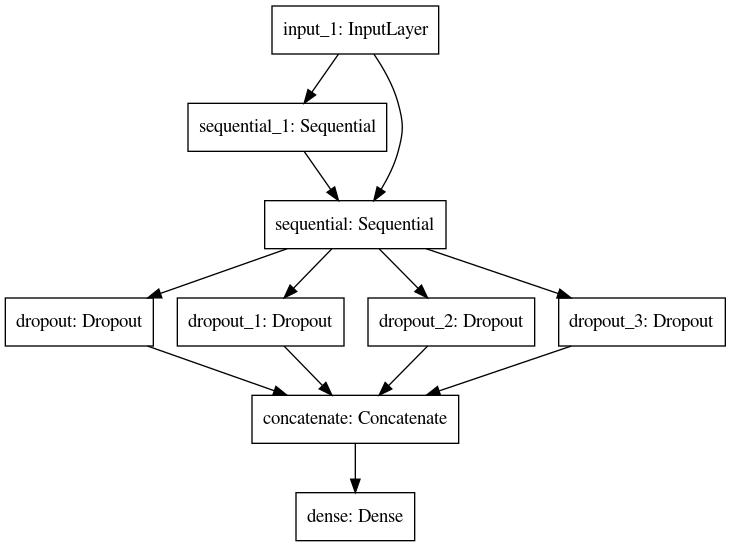

In [7]:
tf.keras.utils.plot_model(seborrheic_model)

In [8]:
seborrheic_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC()])

In [ ]:
sk_train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
history = model.fit(sk_train_ds, validation_data=sk_valid_ds, epochs=20)

Epoch 1/20
63/63 [==============================] - 70s 1s/step - loss: 0.5026 - auc_4: 0.8393 - val_loss: 0.7036 - val_auc_4: 0.8482
Epoch 2/20
63/63 [==============================] - 69s 1s/step - loss: 0.4368 - auc_4: 0.8610 - val_loss: 1.2462 - val_auc_4: 0.7731
Epoch 3/20
63/63 [==============================] - 70s 1s/step - loss: 0.4123 - auc_4: 0.8657 - val_loss: 0.7366 - val_auc_4: 0.8401
Epoch 4/20
63/63 [==============================] - 70s 1s/step - loss: 0.3955 - auc_4: 0.8763 - val_loss: 0.8296 - val_auc_4: 0.8090
Epoch 5/20
63/63 [==============================] - 70s 1s/step - loss: 0.3802 - auc_4: 0.8685 - val_loss: 0.7058 - val_auc_4: 0.8336
Epoch 6/20
63/63 [==============================] - 70s 1s/step - loss: 0.3540 - auc_4: 0.8927 - val_loss: 0.7514 - val_auc_4: 0.8396
Epoch 7/20
63/63 [==============================] - 70s 1s/step - loss: 0.3078 - auc_4: 0.9085 - val_loss: 0.7460 - val_auc_4: 0.8650
Epoch 8/20
63/63 [==============================] - 70s 1s/ste

In [ ]:
model.save('/content/drive/MyDrive/checkpoints')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/assets


In [3]:
seborrheic_model = tf.keras.models.load_model('checkpoints')

In [ ]:
acc, loss = seborrheic_model.evaluate(sk_test_ds, verbose=2)

19/19 - 1467s - loss: 0.8601 - auc_4: 0.8506


In [ ]:
print(f"The testing loss is {loss} and the testing accuracy is {acc}")

The testing loss is 0.8506099581718445 and the testing accuracy is 0.8600600361824036


## Model for Melanoma

In [ ]:
class_names

array(['melanoma', 'nevus', 'seborrheic_keratosis'], dtype='<U20')

In [ ]:
def m_get_label(file_path):
    path = tf.strings.split(file_path, '/')
    label = path[-2]
    
    if label == 'nevus' or label == 'seborrheic_keratosis':
      return 0
    else:
      return 1

In [ ]:
def get_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256,256])

In [ ]:
def m_get_pair(file_path):
    return get_image(file_path), nevus_get_label(file_path)

In [ ]:
m_train_ds = [str(img) for img in training_data.glob("*/*.jpg")]
m_valid_ds = [str(img) for img in validation_data.glob("*/*.jpg")]
m_test_ds  = [str(img) for img in testing_data.glob("*/*.jpg")]

In [ ]:
m_train_ds = tf.data.Dataset.from_tensor_slices(m_train_ds)
m_valid_ds = tf.data.Dataset.from_tensor_slices(m_valid_ds)
m_test_ds = tf.data.Dataset.from_tensor_slices(m_test_ds)

In [ ]:
m_train_ds = m_train_ds.map(m_get_pair)
m_valid_ds = m_valid_ds.map(m_get_pair)
m_test_ds =  m_test_ds.map(m_get_pair)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
m_train_ds = configure_for_performance(m_train_ds)
m_valid_ds = configure_for_performance(m_valid_ds)
m_test_ds =  configure_for_performance(m_test_ds)

In [10]:
# Model taken from https://arxiv.org/ftp/arxiv/papers/1703/1703.03108.pdf
# Model used for Transfer Learning A. Kolesnikov, L. Beyer, X. Zhai, J. Puigcerver, J. Yung, S. Gelly and N. Houlsby: Big Transfer (BiT): General Visual Representation Learning.

IMAGE_SHAPE = (256,256,3)
classifier_model = 'https://tfhub.dev/google/bit/m-r50x1/1'


In [11]:
#img, labels = next(iter(nv_train_ds))

In [22]:
classifier1 = tf.keras.Sequential([
          hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE)
])

In [23]:
data_augmentation = tf.keras.Sequential([
      preprocessing.Rescaling(1./255),
      preprocessing.RandomFlip("horizontal_and_vertical"),
      preprocessing.RandomRotation(0.2),
])

In [24]:
# Creating Ensemble Model

inputs = tf.keras.Input(shape=(256,256,3))
transformation1 = data_augmentation(inputs)
transformation2 = data_augmentation(inputs)
transformation3 = data_augmentation(inputs)

feature_set1 = classifier1(inputs, training=False)
feature_set1 = layers.Dropout(0.5)(feature_set1)

feature_set2 = classifier1(transformation1, training=False)
feature_set2 = layers.Dropout(0.5)(feature_set2)

feature_set3 = classifier1(transformation2, training=False)
feature_set3 = layers.Dropout(0.5)(feature_set3)

feature_set4 = classifier1(transformation3, training=False)
feature_set4 = layers.Dropout(0.5)(feature_set4)

x = layers.concatenate([feature_set1, feature_set2, feature_set3, feature_set4])
output = layers.Dense(1, activation='sigmoid')(x)

melanoma_model = tf.keras.Model(inputs, output)

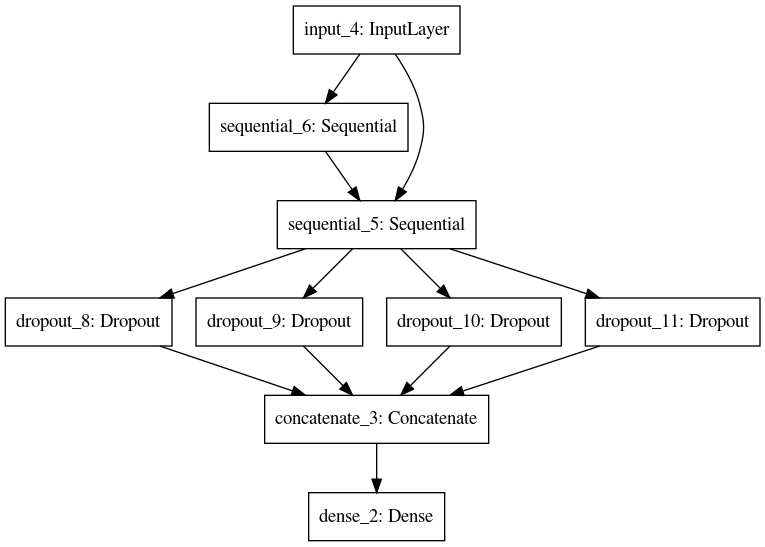

In [25]:
tf.keras.utils.plot_model(melanoma_model)

In [26]:
melanoma_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC()])

In [27]:
m_train_ds.element_spec

NameError: name 'm_train_ds' is not defined

In [ ]:
history = melanoma_model.fit(m_train_ds, validation_data=m_valid_ds, epochs=20)

Epoch 1/20
63/63 [==============================] - 217s 3s/step - loss: 1.7048 - auc_1: 0.5213 - val_loss: 1.0217 - val_auc_1: 0.6897
Epoch 2/20
63/63 [==============================] - 69s 1s/step - loss: 0.9409 - auc_1: 0.7060 - val_loss: 0.6344 - val_auc_1: 0.7765
Epoch 3/20
63/63 [==============================] - 68s 1s/step - loss: 0.8702 - auc_1: 0.7333 - val_loss: 0.6880 - val_auc_1: 0.7354
Epoch 4/20
63/63 [==============================] - 68s 1s/step - loss: 0.6900 - auc_1: 0.7546 - val_loss: 1.1371 - val_auc_1: 0.6554
Epoch 5/20
63/63 [==============================] - 68s 1s/step - loss: 0.7788 - auc_1: 0.7205 - val_loss: 1.0066 - val_auc_1: 0.7346
Epoch 6/20
63/63 [==============================] - 68s 1s/step - loss: 0.6597 - auc_1: 0.7774 - val_loss: 0.6363 - val_auc_1: 0.7708
Epoch 7/20
63/63 [==============================] - 68s 1s/step - loss: 0.8618 - auc_1: 0.7458 - val_loss: 0.5922 - val_auc_1: 0.8110
Epoch 8/20
63/63 [==============================] - 68s 1s/st

In [ ]:
acc, loss = model.evaluate(m_test_ds, verbose=2)

In [ ]:
melanoma_model.save('/content/drive/MyDrive/checkpoints/assets_nv')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/assets_nv/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/assets_nv/assets


## Combining the Models

In [ ]:
melanoma_model = tf.keras.models.load_model('/content/drive/MyDrive/checkpoints/assets_nv')
seborrheic_model = tf.keras.models.load_model('/content/drive/MyDrive/checkpoints')

In [ ]:
acc, loss = seborrheic_model.evaluate(sk_test_ds, verbose=2)

In [ ]:
acc, loss = melanoma_model.evaluate(m_test_ds, verbose=2)

In [ ]:
img, label = train_ds.take(1)

KeyboardInterrupt: ignored

In [28]:
inputs = tf.keras.Input([256,256,3])

m_prediction = melanoma_model(inputs)
sk_prediction = seborrheic_model(inputs)

x = layers.concatenate([m_prediction, tf.ones_like(m_prediction)-m_prediction-sk_prediction, sk_prediction])
output = layers.Activation('softmax')(x)

model = tf.keras.Model(inputs, output)

In [29]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 1)            23508545    input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Shape_1 (TensorFlow [(2,)]               0           functional_7[0][0]               
__________________________________________________________________________________________________
tf_op_layer_Fill_1 (TensorFlowO [(None, 1)]          0           tf_op_layer_Shape_1[0][0]        
_______________________________________________________________________________________

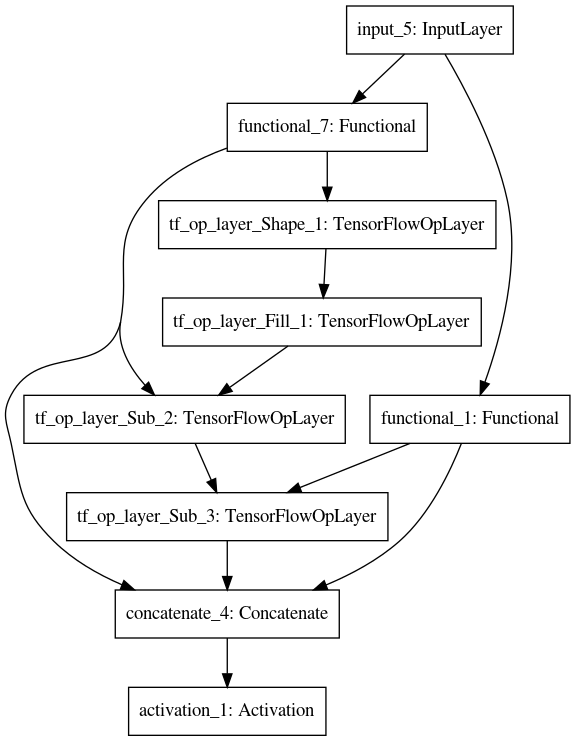

In [30]:
tf.keras.utils.plot_model(model)

In [31]:
model.compile(
    tf.keras.optimizers.Adam(),
    tf.keras.losses.CategoricalCrossentropy(),
    tf.keras.metrics.AUC()
)

In [ ]:
acc, loss = model.evaluate(test_ds, verbose=2)

19/19 - 46s - loss: 0.8752 - auc_4: 0.8041


In [ ]:
model.save('/content/drive/MyDrive/checkpoints/cancer_prediction')

NameError: ignored

In [4]:
model = tf.keras.models.load_model('cancer_prediction')

In [ ]:
image = Image.open('/content/drive/MyDrive/CancerDatasets/datasets/train/melanoma/ISIC_0000002.jpg')
size = (256,256)
image = ImageOps.fit(image, size, Image.ANTIALIAS)
image_array = np.asarray(image)
image_array.shape

(256, 256, 3)

In [ ]:
np.expand_dims(image_array, axis=0).shape

(1, 256, 256, 3)

In [ ]:
model(np.expand_dims(image_array, axis=0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.54707694, 0.23530579, 0.21761724]], dtype=float32)>

In [9]:
model.load_weights('checkpoint')

NameError: name 'model' is not defined